<a href="https://colab.research.google.com/github/borgesbsb/forexneural/blob/main/Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_squared_error # mesma funcao do MSE
import pickle as pkl



In [12]:
class Processing:
    def __init__(self, currency, begining_training, end_training,begin_validate,end_validate, timestamp, features, target):
        self.timestamp = timestamp
        self.currency = currency
        self.features  = features
        self.target    = target
        self.begining_training = begining_training
        self.end_training      = end_training
        self.begin_validate    = begin_validate
        self.end_validate      = end_validate
        self.df  = self.importDataset()
        self.x_train =     []
        self.y_train =     []
        self.x_test  =     []
        self.y_test  =     []
        self.x_validate =  []
        self.y_validate =  []
        self.scaler_x =    None
        self.scaler_y =    None
        self.target =      target
        self.df_training = None
        self.df_test =     None
        self.df_validade = None
        self.splitData()

    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        # df = pd.read_csv( '../csv/EURUSD-15M-1H.csv', sep=',', header=0, parse_dates=['time'],date_parser=parser) 
        df = pd.read_csv( '/content/drive/MyDrive/csv/EURUSD-15M-1H.csv', sep=',', header=0, parse_dates=['time'],date_parser=parser) 
        return df

    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]

    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df_training[[self.target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        for i in range(self.timestamp, length-3):
            x_data.append( dataframe[i-self.timestamp:i,:])
            y_data.append( dataframe[i+3,self.features.index('close4')])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(self.features)))
        return x_data, y_data

    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        self.x_train = self.scalerDataset(self.df_training)
        self.x_train, self.y_train = self.processXY(self.x_train)
        #Selecionando Intervalos de datas para teste
        self.df_test     = self.selectInterval(self.end_training,   self.begin_validate)
        self.df_validate = self.selectInterval(self.begin_validate, self.end_validate)
       
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        self.x_validate = self.df_validate[self.features]
        
        #Escalando o dataset de treino
        self.x_test = self.scaler_x.transform(self.x_test)
        self.x_validate = self.scaler_x.transform(self.x_validate)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )
        self.x_validate, self.y_validate = self.processXY( self.x_validate )



In [15]:
class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
    
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False,    input_shape=( self.timestamp , len(self.features) ) ))
        # self.model.add(Dense(800))
        self.model.add(Dense(1))

        # self.model.add(Dropout(0.01))

    def trainingLSTM(self):
        from matplotlib import pyplot
        self.configuringLSTM()
        self.model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs,  verbose=1, validation_data=(self.ds.x_test,self.ds.y_test))
        pyplot.plot(self.model.history.history['loss'])
        pyplot.plot(self.model.history.history['val_loss'])
        pyplot.title('model train vs validation loss with = '+str(self.epochs) + ' epochs and = '+str(self.neurons)+' Neurons ' )
        pyplot.ylabel('loss')
        pyplot.xlabel('epoch')
        pyplot.legend(['train', 'validation'], loc='upper right')
        pyplot.show()

    

    def saveLSTM(self):
        self.model.save('/content/drive/MyDrive/csv/LSTM_'+self.ds.currency)
        with open("/content/drive/MyDrive/csv/scaler_x.pkl", "wb") as scaler_x:
            pkl.dump(self.ds.scaler_x, scaler_x)
        with open("/content/drive/MyDrive/csv/scaler_y.pkl", "wb") as scaler_y:
            pkl.dump(self.ds.scaler_y, scaler_y)

In [4]:
class Testing:
    def __init__(self, modelTraining, ds):
        self.modelTraining = modelTraining
        self.ds = ds
        self.y_pred = []
        self.predictedPrice = []
        self.predictedPrice_validate = []
        self.prevision = None
        self.prevision_validate = None
        self.time = None
        self.time_validate = None
        self.max = None
        self.max_validate = None
        self.min = None
        self.min_validate = None
        self.open = None
        self.result_to_csv = None
        self.result_to_csv_validate = None
        self.predicting()
        self.estatistical()
        self.rmse = 0
        self.acuracy = self.estatistical_pred(len(self.predictedPrice))
        
    def predicting(self):
        self.predictedPrice = self.modelTraining.model.predict(
            self.ds.x_test)
        self.predictedPrice_validate = self.modelTraining.model.predict(
            self.ds.x_validate)
        self.predictedPrice = self.ds.scaler_y.inverse_transform(
            self.predictedPrice)
        self.predictedPrice_validate = self.ds.scaler_y.inverse_transform(
            self.predictedPrice_validate)
        self.rmse = mean_squared_error(self.ds.y_test, self.predictedPrice, squared=False)
        

    
    def estatistical(self):
        self.y_test = pd.DataFrame(data=self.ds.df_test['close4'].shift(-(self.ds.timestamp+3)).dropna().values, columns=['Y_TEST'] )
        self.open = pd.DataFrame(data=self.ds.df_test['open1'].shift(-(self.ds.timestamp+3)).dropna().values, columns=['Abertura'])
        self.prevision = pd.DataFrame( data=self.predictedPrice, columns=['Previsão'])
        self.prevision_validate = pd.DataFrame( data=self.predictedPrice_validate, columns=['Previsão'])
        self.time = pd.DataFrame( data=self.ds.df_test['time'].shift(-(self.ds.timestamp+3)).dropna().values, columns=['Data'])
        self.time_validate = pd.DataFrame( data=self.ds.df_validate['time'].shift(-(self.ds.timestamp+3)).dropna().values, columns=['Data'])
        
        self.maxima = pd.DataFrame(data=self.ds.df_test[['max1','max2','max3']].max(axis=1).shift(-(self.ds.timestamp+3)).dropna().values, columns=['Máxima'])
        
        self.maxima_validate = pd.DataFrame(data=self.ds.df_validate[['max1','max2','max3','max4']].max(axis=1).shift(-(self.ds.timestamp+3)).dropna().values, columns=['Máxima'])
                      
        self.minima = pd.DataFrame(data=self.ds.df_test[['min1','min2','min3']].min(axis=1).shift(-(self.ds.timestamp+3)).dropna().values, columns=['Minima'])
        
        self.minima_validate = pd.DataFrame(data=self.ds.df_validate[['min1','min2','min3','min4']].min(axis=1).shift(-(self.ds.timestamp+3)).dropna().values, columns=['Minima'])
        
        frames_to_csv = [ self.time, self.maxima, self.minima, self.prevision]
        frames_to_csv_validate = [ self.time_validate, self.maxima_validate, self.minima_validate, self.prevision_validate]
        self.result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
        self.result_to_csv_validate = pd.concat( frames_to_csv_validate, axis=1, join='inner')

    def saveToCsv(self):
        self.result_to_csv_validate.to_csv(
            'previsoes_'+self.ds.currency, mode='a', header=False, index=False)

    def graphicMaxMin(self, window):
        y_test = []
        y_test = self.ds.df_test['close4'].shift(
            -self.ds.timestamp).dropna()
        plt.plot(y_test[:window], color='red',
                  label='Preço Atual das Ações')
        plt.plot(
            y_test.index.values[:window], self.prevision.iloc[:window, 0], '.')
        plt.fill_between(
            y_test.index.values[:window], self.maxima.iloc[:window, 0], self.minima.iloc[:window, 0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
        print(self.modelTraining.model.evaluate(
            self.ds.x_test, y_test, verbose=0)*100)

    def estatistical_pred(self, window):
        self.acertos = 0
        resumo_acumulado = []
        self.erros = 0
        for i in range(window):
            soma = 0
            if self.prevision.iloc[i, 0] in pd.Interval(left=self.minima.iloc[i, 0], right=self.maxima.iloc[i, 0]):
                soma = abs(
                    self.prevision.iloc[i, 0] - self.open.iloc[i, 0])
                soma = int(soma*100000)
                self.acertos = self.acertos + 1
            else:
                if self.y_test.iloc[i, 0] > self.open.iloc[i, 0]:
                    if self.prevision.iloc[i, 0] > self.open.iloc[i, 0]:
                        soma = abs(
                            self.y_test.iloc[i, 0] - self.open.iloc[i, 0])
                        soma = int(soma*10000)
                        self.acertos = self.acertos + 1
                    else:
                        soma = self.open.iloc[i, 0] - \
                            self.y_test.iloc[i, 0]
                        soma = int(soma*10000)
                        self.erros = self.erros + 1
                else:
                    if self.prevision.iloc[i, 0] < self.open.iloc[i, 0]:
                        soma = abs(
                            self.y_test.iloc[i, 0] - self.open.iloc[i, 0])
                        soma = int(soma*10000)
                        self.acertos = self.acertos + 1
                    else:
                        soma = self.y_test.iloc[i,
                                                0] - self.open.iloc[i, 0]
                        soma = int(soma*10000)
                        self.erros = self.erros + 1
        portcentagem = self.acertos*100/window
        print("Acertos: ", self.acertos)
        print("Erros: ", self.erros)
        print("%", portcentagem)
        resumo_acumulado = pd.DataFrame(
        data=resumo_acumulado, columns=['Resumo Acumulado '])
        return portcentagem

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# def running_test(epochs,neurons):
#     begining_training = '2016-01-01 00:00:00'
#     end_training =      '2021-11-03 00:00:00'
#     begin_validate =    '2017-04-03 00:00:00'
#     end_validate =      '2017-05-03 00:00:00'
#     currency          = 'EURUSD-15M-1H'
#     features          = ['open1','max1','min1','open2','max2','min2','open3','max3','min3','open4','max4','min4','close4']
#     target            = 'close4'
#     timestamp = 2
#     neurons = 3200
#     epochs  = 150
#     datasetProcessed = Processing( currency, begining_training, end_training, begin_validate, end_validate, timestamp, features, target  )
#     modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )
#     return datasetProcessed, modelTrained

In [7]:
# dataset, model = running_test(epochs=150,neurons=3200)
# estatisticalTested  = Testing( model, dataset )
# # estatisticalTested  = Testing( model, dataset )
# if estatisticalTested.acuracy > best_accuracy:
#       best_accuracy = estatisticalTested.acuracy
#       print('Melhor Aproveitamento = '+str(np.round(best_accuracy,2))+'%')
#       print('Acertos = '+str(estatisticalTested.acertos))
#       print('Erros = '+str(estatisticalTested.erros)+'\n')
#       save_to_csv = estatisticalTested

In [8]:
# estatisticalTested.predicting()

In [9]:
# estatisticalTested.saveToCsv()

# Nova seção

In [10]:
# estatisticalTested  = Testing( model, dataset )
# if estatisticalTested.acuracy > best_accuracy:
#       best_accuracy = estatisticalTested.acuracy
#       best_epochs = epochs_i
#       best_neurons = neurons_i
#       print('Melhor Aproveitamento = '+str(np.round(best_accuracy,2))+'%')
#       print('Epochs = ',best_epochs)
#       print('Neurons = ', best_neurons)
#       print('Acertos = '+str(estatisticalTested.acertos))
#       print('Erros = '+str(estatisticalTested.erros)+'\n')
#       save_to_csv = estatisticalTested

Ano = 2021 - Mes = 11 - Neurons = 3200 -  Epochs = 150 - Loop = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


Epoch 1/5
4664/4664 [==============================] - 18s 4ms/step - loss: 0.0065 - accuracy: 1.3403e-05 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 2/5
4664/4664 [==============================] - 16s 4ms/step - loss: 0.0041 - accuracy: 1.3403e-05 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 3/5
4664/4664 [==============================] - 16s 4ms/step - loss: 0.0040 - accuracy: 1.3403e-05 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 4/5
4664/4664 [==============================] - 16s 4ms/step - loss: 0.0038 - accuracy: 1.3403e-05 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 5/5
4664/4664 [==============================] - 16s 3ms/step - loss: 0.0037 - accuracy: 1.3403e-05 - val_loss: 0.0029 - val_accuracy: 0.0000e+00


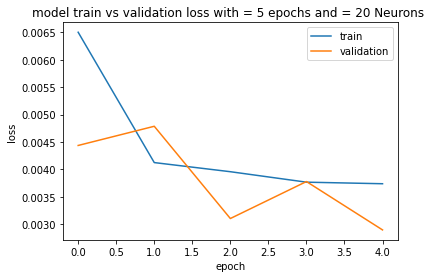

Acertos:  1753
Erros:  349
% 83.39676498572788
Melhor Aproveitamento = 83.4%
Acertos = 1753
Erros = 349



In [18]:
best_accuracy = 0
for ano in range(2021,2022):
    for mes in range(11,12):
        if mes == 0:
            print('Ano = '+str(ano)+' - '+ 'Mes = '+str(mes)+' - Neurons = '+str(3200)+' -  Epochs = '+str(150)+' - Loop = '+str(1) )    
            begining_training = str(ano-6)+'-01'+'-01 00:00:00'
            end_training      = str(ano-1)+'-12'+'-30 00:00:00'
            begin_validate    = str(ano)+'-01'+'-03 00:00:00'
            end_validate      = str(ano)+'-02'+'-01 00:00:00'
        else:
            print('Ano = '+str(ano)+' - '+ 'Mes = '+str(mes)+' - Neurons = '+str(3200)+' -  Epochs = '+str(150)+' - Loop = '+str(1) )    
            begining_training = str(ano-6)+'-'+str(mes)+'-01 00:00:00'
            end_training      = str(ano)+'-'+str(mes)+'-01 00:00:00'
            begin_validate    = str(ano)+'-'+str(mes+1)+'-01 00:00:00'
            if mes+2 < 13:
                end_validate      = str(ano)+'-'+str(mes+2)+'-01 00:00:00'
            else:
                end_validate      = str(ano)+'-'+'12'+'-30 00:00:00'
        
        currency          = 'EURUSD-15M-1H'
        features          = ['open1','max1','min1','open2','max2','min2','open3','max3','min3','open4','max4','min4','close4']
        target            = 'close4'
        timestamp = 2
        neurons = 20
        epochs  = 5
        datasetProcessed = Processing( currency, begining_training, end_training, begin_validate, end_validate, timestamp, features, target  )
        modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )
        estatisticalTested  = Testing( modelTrained, datasetProcessed )
        if estatisticalTested.acuracy > best_accuracy:
                         best_accuracy = estatisticalTested.acuracy
                         print('Melhor Aproveitamento = '+str(np.round(best_accuracy,2))+'%')
                         print('Acertos = '+str(estatisticalTested.acertos))
                         print('Erros = '+str(estatisticalTested.erros)+'\n')
                         save_to_csv = estatisticalTested


In [ ]:
save_to_csv.saveToCsv()